In [1]:
import pandas
from pathlib import Path
from matplotlib import pyplot
from collections import Counter
import numpy
import scanpy
import pysam

In [2]:
def scanpy_load_solo_278_mtx(analysis_dir, gene="Gene", mode="filtered", matrix="matrix.mtx"):
    assert gene in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert matrix in ["matrix.mtx", "UniqueAndMult-EM.mtx"]

    analysis_dir = Path(analysis_dir)
    solo_dir = analysis_dir / "Solo.out" / gene / mode
    solo = scanpy.read_mtx(solo_dir / matrix).T
    solo_vars = pandas.read_csv(
        solo_dir / "features.tsv", header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo


In [3]:
analysis_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc/fullsolo_multi_eoi_container").expanduser()
solo_dir = analysis_dir / "Solo.out"
gene_dir = solo_dir / "GeneFull_Ex50pAS"
umi_file = gene_dir / "UMIperCellSorted.txt"

In [4]:
umi = pandas.read_csv(umi_file, header=None)

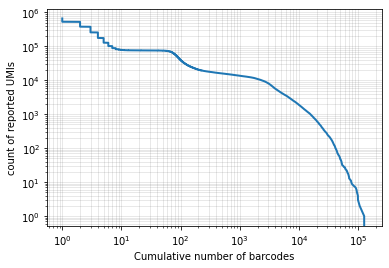

In [5]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

ax.plot(umi[0], umi.index, linewidth=2)

ax.set_xlabel('Cumulative number of barcodes')
ax.set_ylabel('count of reported UMIs')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(1,1e5)
#ax.set_ylim(1,1e6)
ax.grid(color="dimgrey", linestyle="-", linewidth=0.5, which="both", alpha=0.3)

In [6]:
solo_count = scanpy_load_solo_278_mtx(analysis_dir, "GeneFull_Ex50pAS", "raw")

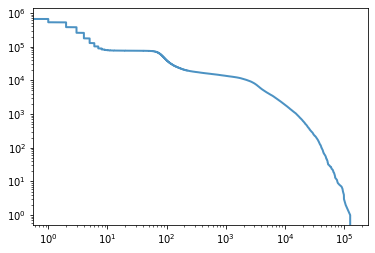

In [7]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

solo_ranked_umi = numpy.sort(numpy.array(solo_count.obs['counts']), axis=None)[::-1]
ax.plot(solo_ranked_umi,  range(solo_ranked_umi.shape[0]), linewidth=2, alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')

In [8]:
cb_filtered = []
with open(gene_dir / "filtered" / "barcodes.tsv", "rt") as instream:
    for line in instream:
        cb_filtered.append(line.rstrip())

In [9]:
genome_dir = Path("~/proj/genome/GRCh38-V29-male-2.7.8a").expanduser()
store = pandas.HDFStore(genome_dir / "GRCh38-V29-male-2.7.8a.h5")
gene_types = store.select("/gtf", where="type=gene or type=spikein or type=tRNAscan", columns=["gene_id", "gene_type"])
store.close()

In [10]:
gene_types

,gene_id,gene_type
649,ENSG00000223972.5,transcribed_unprocessed_pseudogene
661,ENSG00000227232.5,unprocessed_pseudogene
674,ENSG00000278267.1,miRNA
677,ENSG00000243485.5,lincRNA
685,ENSG00000284332.1,miRNA
...,...,...
2743285,ENSG00000276017.1,protein_coding
2743292,ENSG00000278817.1,protein_coding
2743308,ENSG00000277196.4,protein_coding
2743377,ENSG00000278625.1,snRNA


In [11]:
gene_type_lookup = gene_types.set_index('gene_id')['gene_type'].to_dict()

In [12]:
gene_types.set_index('gene_id').to_dict

<bound method DataFrame.to_dict of                                             gene_type
gene_id                                              
ENSG00000223972.5  transcribed_unprocessed_pseudogene
ENSG00000227232.5              unprocessed_pseudogene
ENSG00000278267.1                               miRNA
ENSG00000243485.5                             lincRNA
ENSG00000284332.1                               miRNA
...                                               ...
ENSG00000276017.1                      protein_coding
ENSG00000278817.1                      protein_coding
ENSG00000277196.4                      protein_coding
ENSG00000278625.1                               snRNA
ENSG00000277374.1                               snRNA

[58780 rows x 1 columns]>

In [13]:
bam = analysis_dir / "Aligned.sortedByCoord.out.bam"

In [14]:
raw_gene_types = Counter()
filtered_gene_types = Counter()
cb_set = set(cb_filtered)
with pysam.AlignmentFile(bam, "rb") as alignment:
    for read in alignment:
        if read.has_tag("CB"):
            cb = read.get_tag("CB")
        else:
            continue
        if read.has_tag("gx"):
            gx = read.get_tag("gx").split(";")
        elif read.has_tag("GX"):
            gx = read.get_tag("GX").split(";")
        if gx[0] == '-':
            raw_gene_types['genomic'] += 1
        else:
            if cb in cb_set:
                read_passed_filter = True
            else:
                read_passed_filter = False
            for gene_id in gx:
                if gene_id in gene_type_lookup:
                    read_type = gene_type_lookup[gene_id]
                    raw_gene_types[read_type] += 1/len(gx)
                    
                    if read_passed_filter:
                        filtered_gene_types[read_type] += 1/len(gx)

In [15]:
pandas.Series(raw_gene_types).sort_values(ascending=False)

genomic                               1.767529e+08
protein_coding                        1.646530e+08
lincRNA                               3.430935e+07
processed_pseudogene                  5.785250e+06
antisense                             5.378819e+06
transcribed_unprocessed_pseudogene    2.156918e+06
processed_transcript                  1.840363e+06
unprocessed_pseudogene                8.671031e+05
transcribed_processed_pseudogene      7.090335e+05
Mt_rRNA                               5.677740e+05
misc_RNA                              4.541038e+05
sense_intronic                        3.759373e+05
snRNA                                 2.953695e+05
transcribed_unitary_pseudogene        2.151450e+05
sense_overlapping                     1.634730e+05
TEC                                   1.625322e+05
bidirectional_promoter_lncRNA         8.776067e+04
polymorphic_pseudogene                6.582000e+04
snoRNA                                3.592150e+04
scRNA                          

In [16]:
pandas.Series(filtered_gene_types).sort_values(ascending=False)

protein_coding                        1.429250e+08
lincRNA                               2.532579e+07
antisense                             4.822691e+06
processed_pseudogene                  4.118952e+06
transcribed_unprocessed_pseudogene    1.979198e+06
processed_transcript                  1.657542e+06
unprocessed_pseudogene                7.793337e+05
transcribed_processed_pseudogene      5.573465e+05
Mt_rRNA                               4.125950e+05
sense_intronic                        3.562220e+05
misc_RNA                              3.560175e+05
transcribed_unitary_pseudogene        1.972510e+05
snRNA                                 1.774420e+05
sense_overlapping                     1.521514e+05
TEC                                   1.480747e+05
bidirectional_promoter_lncRNA         8.097283e+04
polymorphic_pseudogene                4.790150e+04
snoRNA                                2.872600e+04
rRNA                                  2.297550e+04
3prime_overlapping_ncRNA       

In [17]:
all_raw = scanpy_load_solo_278_mtx(analysis_dir, "GeneFull_Ex50pAS", "raw", "UniqueAndMult-EM.mtx")

In [18]:
all_raw

AnnData object with n_obs × n_vars = 736320 × 59526
    obs: 'counts', 'ngenes'

In [23]:
all_filtered = all_raw[cb_filtered,:]

all_filtered.obs["counts"] = all_filtered.X.sum(axis=1)
all_filtered.obs["ngenes"] = numpy.array((all_filtered.X > 0).sum(axis=1))

Trying to set attribute `.obs` of view, copying.


In [24]:
all_filtered

AnnData object with n_obs × n_vars = 15708 × 59526
    obs: 'counts', 'ngenes'

In [26]:
all_filtered.obs['counts']

AAACAGCCAAATGCCC      705.999939
AAACAGCCACGTGCTG    15964.000000
AAACAGCCACTTAGGC    18922.000000
AAACAGCCAGGGAGCT     4464.000000
AAACAGCCATGTTTGG     3846.000000
                        ...     
TTTGTTGGTGAGCAAG     1291.000000
TTTGTTGGTGCTCACC     5044.000000
TTTGTTGGTGCTTACT     5398.000000
TTTGTTGGTGCTTAGA     2534.000000
TTTGTTGGTTACATCC     2715.000000
Name: counts, Length: 15708, dtype: float32

In [29]:
all_filtered.X.sum(axis=0).shape

(1, 59526)

In [30]:
all_filtered

AnnData object with n_obs × n_vars = 15708 × 59526
    obs: 'counts', 'ngenes'

In [33]:
all_filtered.var_names

Index(['ENSG00000223972.5', 'ENSG00000227232.5', 'ENSG00000278267.1',
       'ENSG00000243485.5', 'ENSG00000284332.1', 'ENSG00000237613.2',
       'ENSG00000268020.3', 'ENSG00000240361.2', 'ENSG00000186092.6',
       'ENSG00000238009.6',
       ...
       'gSpikein_ERCC-00158', 'gSpikein_ERCC-00160', 'gSpikein_ERCC-00162',
       'gSpikein_ERCC-00163', 'gSpikein_ERCC-00164', 'gSpikein_ERCC-00165',
       'gSpikein_ERCC-00168', 'gSpikein_ERCC-00170', 'gSpikein_ERCC-00171',
       'gSpikein_phiX174'],
      dtype='object', length=59526)

In [40]:
all_filtered.var['count'] = all_filtered.X.sum(axis=0).T

In [42]:
for key in all_filtered.var['count']:
    print(key)
    break

23.24999237060547


In [48]:
for row in all_filtered.var['count'].iteritems()